In [42]:
import numpy as np
import pandas as pd
import re
import string

## Read Data

In [43]:
# read data
column_names = ["sentiment", "title", "content"]
df = pd.read_csv('C:/Users/ROG/Desktop/train.csv', header=None, names=column_names)
# fill na value
#df = df.head(10000)
df['title'].fillna("", inplace=True)
df['sentiment'] = df['sentiment'] - 1

## Data Cleaning

In [44]:
def clean_text(text):
    # HTML
    text = re.sub(r'<.*?>', '', text)
    # lowercase
    text = text.lower()
    # remove punctuation and numbers
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\d+', '', text)
    return text

df['title_cleaned'] = df['title'].apply(clean_text)
df['content_cleaned'] = df['content'].apply(clean_text)

df[['title', 'title_cleaned', 'content', 'content_cleaned']].head()

,title,title_cleaned,content,content_cleaned
0,Stuning even for the non-gamer,stuning even for the nongamer,This sound track was beautiful! It paints the ...,this sound track was beautiful it paints the s...
1,The best soundtrack ever to anything.,the best soundtrack ever to anything,I'm reading a lot of reviews saying that this ...,im reading a lot of reviews saying that this i...
2,Amazing!,amazing,This soundtrack is my favorite music of all ti...,this soundtrack is my favorite music of all ti...
3,Excellent Soundtrack,excellent soundtrack,I truly like this soundtrack and I enjoy video...,i truly like this soundtrack and i enjoy video...
4,"Remember, Pull Your Jaw Off The Floor After He...",remember pull your jaw off the floor after hea...,"If you've played the game, you know how divine...",if youve played the game you know how divine t...


In [45]:
# disjunction words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# word list
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words])

df['title_cleaned'] = df['title_cleaned'].apply(remove_stopwords)
df['content_cleaned'] = df['content_cleaned'].apply(remove_stopwords)

df[['title', 'title_cleaned', 'content', 'content_cleaned']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ROG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,title,title_cleaned,content,content_cleaned
0,Stuning even for the non-gamer,stuning even nongamer,This sound track was beautiful! It paints the ...,sound track beautiful paints senery mind well ...
1,The best soundtrack ever to anything.,best soundtrack ever anything,I'm reading a lot of reviews saying that this ...,im reading lot reviews saying best game soundt...
2,Amazing!,amazing,This soundtrack is my favorite music of all ti...,soundtrack favorite music time hands intense s...
3,Excellent Soundtrack,excellent soundtrack,I truly like this soundtrack and I enjoy video...,truly like soundtrack enjoy video game music p...
4,"Remember, Pull Your Jaw Off The Floor After He...",remember pull jaw floor hearing,"If you've played the game, you know how divine...",youve played game know divine music every sing...


In [46]:
# stem extraction or word form reduction
#nltk.download('omw-1.4')
#nltk.download('wordnet')
#lemmatizer = WordNetLemmatizer()
from nltk.stem import PorterStemmer

# use Porter
stemmer = PorterStemmer()
def stem_text(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

df['title_cleaned'] = df['title_cleaned'].apply(stem_text)
df['content_cleaned'] = df['content_cleaned'].apply(stem_text)

df[['title', 'title_cleaned', 'content', 'content_cleaned']].head()

,title,title_cleaned,content,content_cleaned
0,Stuning even for the non-gamer,stune even nongam,This sound track was beautiful! It paints the ...,sound track beauti paint seneri mind well woul...
1,The best soundtrack ever to anything.,best soundtrack ever anyth,I'm reading a lot of reviews saying that this ...,im read lot review say best game soundtrack fi...
2,Amazing!,amaz,This soundtrack is my favorite music of all ti...,soundtrack favorit music time hand intens sad ...
3,Excellent Soundtrack,excel soundtrack,I truly like this soundtrack and I enjoy video...,truli like soundtrack enjoy video game music p...
4,"Remember, Pull Your Jaw Off The Floor After He...",rememb pull jaw floor hear,"If you've played the game, you know how divine...",youv play game know divin music everi singl so...


## Description and Visualization

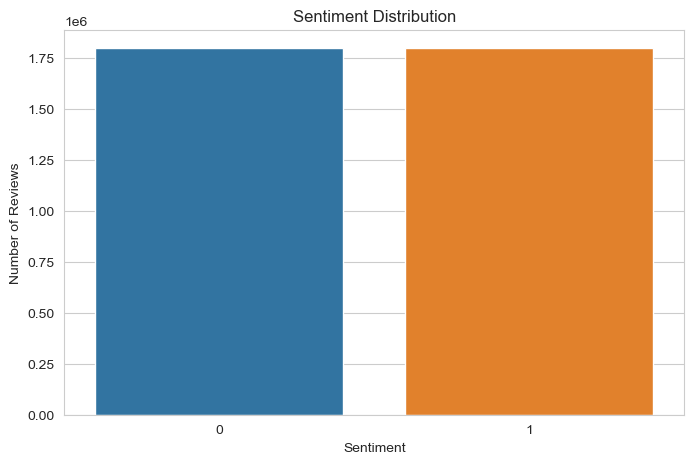

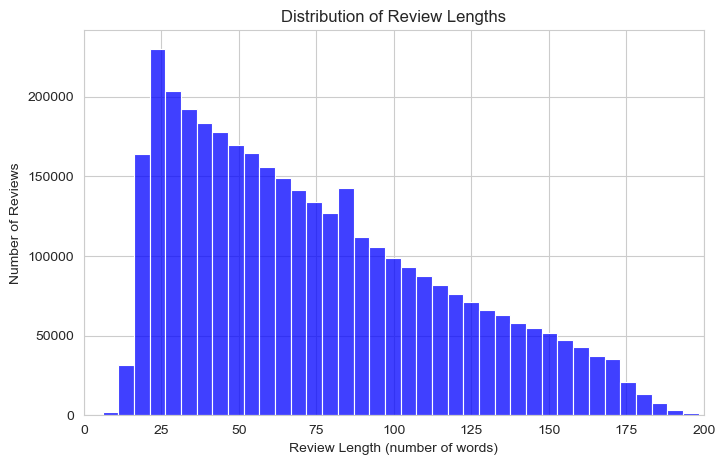

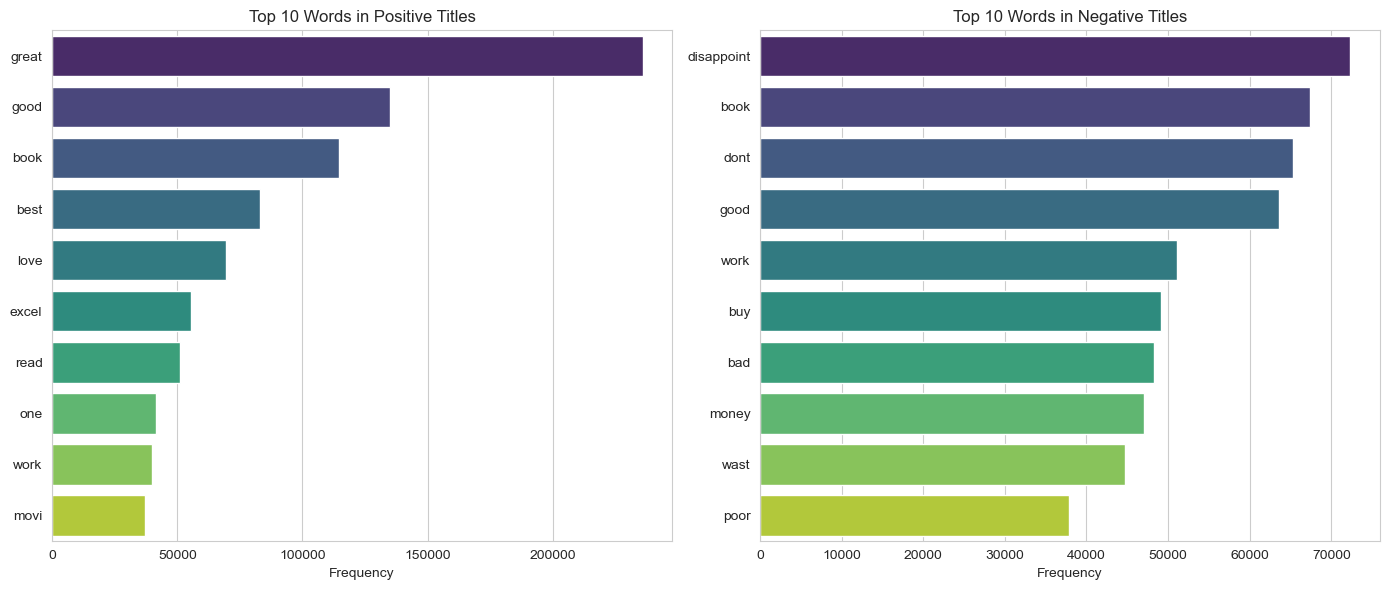

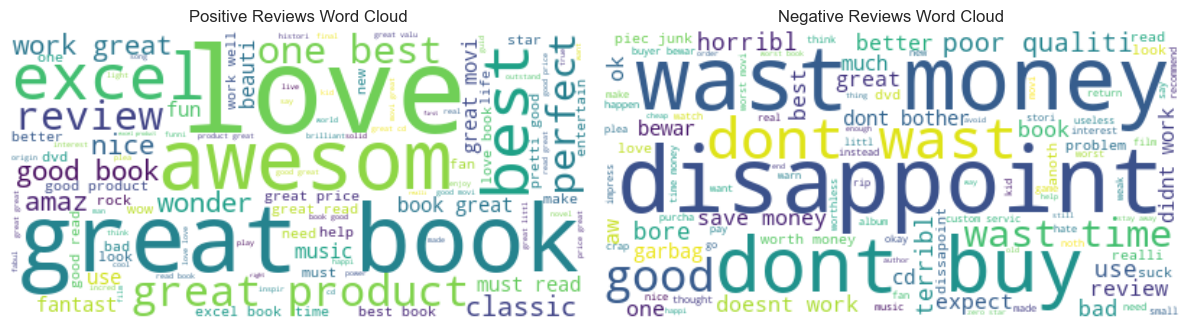

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

# style setting
sns.set_style("whitegrid")

# 1. sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='sentiment')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

# 2. length distrition
df['content_length'] = df['content'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 5))
sns.histplot(df['content_length'], bins=50, color='blue')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (number of words)')
plt.ylabel('Number of Reviews')
plt.xlim(0, 200)  # Limiting to 200 for better visibility
plt.show()

# 3. common words
positive_words = ' '.join(df[df['sentiment'] == 1]['title_cleaned'])
negative_words = ' '.join(df[df['sentiment'] == 0]['title_cleaned'])
positive_word_freq = Counter(positive_words.split())
negative_word_freq = Counter(negative_words.split())
# top10
top10_positive_words = positive_word_freq.most_common(10)
top10_negative_words = negative_word_freq.most_common(10)

plt.figure(figsize=(14, 6))
# Positive Titles Word Frequency
plt.subplot(1, 2, 1)
sns.barplot(x=[item[1] for item in top10_positive_words], 
            y=[item[0] for item in top10_positive_words], palette="viridis")
plt.title('Top 10 Words in Positive Titles')
plt.xlabel('Frequency')

# Negative Titles Word Frequency
plt.subplot(1, 2, 2)
sns.barplot(x=[item[1] for item in top10_negative_words], 
            y=[item[0] for item in top10_negative_words], palette="viridis")
plt.title('Top 10 Words in Negative Titles')
plt.xlabel('Frequency')

plt.tight_layout()
plt.show()

# 4. word cloud
plt.figure(figsize=(12, 6))

# Positive Word Cloud
plt.subplot(1, 2, 1)
wordcloud = WordCloud(background_color="white", max_words=100).generate(positive_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews Word Cloud')

# Negative Word Cloud
plt.subplot(1, 2, 2)
wordcloud = WordCloud(background_color="white", max_words=100).generate(negative_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews Word Cloud')

plt.tight_layout()
plt.show()


## Model

In [48]:
# logistic
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
# train test split
X = df['content_cleaned']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# use TF-IDF performing feature extraction
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
# model fit
clf = LogisticRegression()
clf.fit(X_train_tfidf, y_train)
# prediction
y_pred = clf.predict(X_test_tfidf)
# results
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

accuracy, classification_rep

d:\python\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.8620611111111111,
 '              precision    recall  f1-score   support\n\n           0       0.86      0.86      0.86    359759\n           1       0.86      0.87      0.86    360241\n\n    accuracy                           0.86    720000\n   macro avg       0.86      0.86      0.86    720000\nweighted avg       0.86      0.86      0.86    720000\n')

In [49]:
# transformer
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset, random_split
# load BERT and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', use_fast=True)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [53]:
# data preprocessing
sub_df = df.head(100000)
inputs = tokenizer.batch_encode_plus(list(sub_df['content_cleaned']), truncation=True, padding=True, max_length=256, return_tensors='pt')
input_ids = inputs["input_ids"]
attention_masks = inputs["attention_mask"]
labels = torch.tensor(sub_df['sentiment'].values)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
input_ids = input_ids.to(device)
attention_masks = attention_masks.to(device)
labels = labels.to(device)
# construct PyTorch datatset
dataset = TensorDataset(input_ids, attention_masks, labels)
# split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)

In [54]:
# fine tune
from tqdm import tqdm
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(3):  # 3 rounds
    model.train()
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch}"):
        input_ids, attention_masks, labels = batch
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

# evaluation
model.eval()
all_preds, all_labels = [], []
for batch in val_loader:
    input_ids, attention_masks, labels = batch
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_masks)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)
    all_preds.extend(preds)
    all_labels.extend(labels)

accuracy = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean()
print(f"Validation Accuracy: {accuracy:.4f}")


Training Epoch 0:   2%|▏         | 40/2500 [00:24<25:16,  1.62it/s]


KeyboardInterrupt: 